<a href="https://colab.research.google.com/github/Aneesanavi/ML-models-Longevity/blob/main/Heartdiseaseprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Features with all missing values (skipped): ['BMIHEAD', 'DRQSDT5', 'MCQ240I', 'MCQ240R', 'MCQ240V', 'SMQ690J', 'SMQ861']
RandomForest - Accuracy: 0.98, Precision: 0.98, Recall: 0.96, F1: 0.97, ROC AUC: 1.00
GradientBoosting - Accuracy: 0.99, Precision: 0.98, Recall: 0.98, F1: 0.98, ROC AUC: 1.00
NeuralNetwork - Accuracy: 0.97, Precision: 0.96, Recall: 0.95, F1: 0.96, ROC AUC: 0.99

Model Comparison:
                  Accuracy  Precision    Recall  F1 Score   ROC AUC
RandomForest      0.977273   0.984203  0.955971  0.969882  0.997671
GradientBoosting  0.987743   0.983989  0.983989  0.983989  0.998854
NeuralNetwork     0.966803   0.961564  0.951301  0.956405  0.992220

Top 10 Features by Importance:
       Feature  Importance
491      BMXWT    0.308638
503    BMXARMC    0.263732
398    LBDTCSI    0.151743
505   BMXWAIST    0.104672
496      BMXHT    0.056073
1741    WHQ030    0.027672
508    BMXSAD2    0.022647
1739    WHD010    0.017684
507    BMXSAD1    0.015329
2     RIAGENDR    0.007

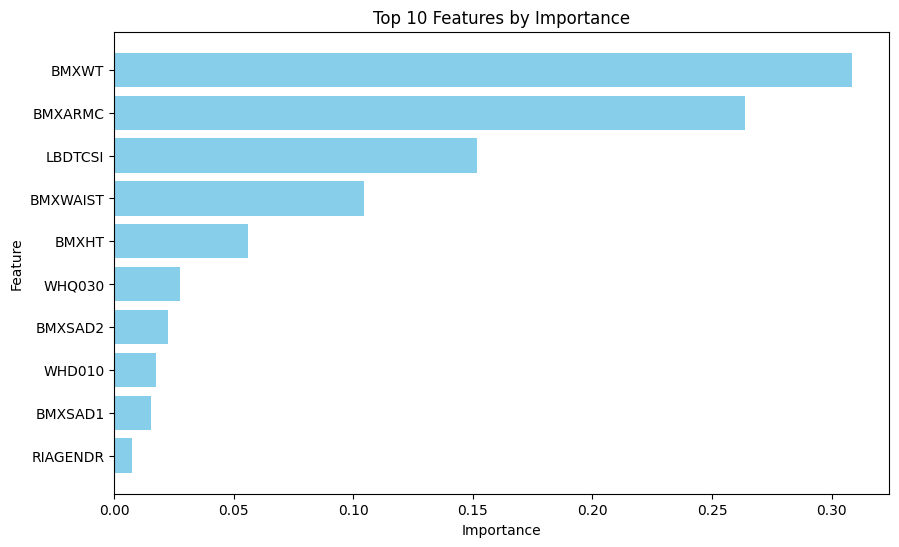

['best_risk_prediction_model.pkl']

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Step 1: Load Datasets with Encoding Handling
demographic = pd.read_csv('demographic.csv', encoding='ISO-8859-1')
labs = pd.read_csv('labs.csv', encoding='ISO-8859-1')
examination = pd.read_csv('examination.csv', encoding='ISO-8859-1')
diet = pd.read_csv('diet.csv', encoding='ISO-8859-1')
medications = pd.read_csv('medications.csv', encoding='ISO-8859-1')
questionnaire = pd.read_csv('questionnaire.csv', encoding='ISO-8859-1')

# Step 2: Merge Datasets Using 'SEQN' as the Key
data = demographic.merge(labs, on='SEQN', how='inner') \
                  .merge(examination, on='SEQN', how='inner') \
                  .merge(diet, on='SEQN', how='inner') \
                  .merge(medications, on='SEQN', how='inner') \
                  .merge(questionnaire, on='SEQN', how='inner')

# Drop 'SEQN' after merging
data.drop(columns=['SEQN'], inplace=True)

# Step 3: Define Target Variable (Risk of Age-Related Diseases)
if 'BMXBMI' not in data.columns or 'LBXTC' not in data.columns:
    raise ValueError("Required columns for cardiovascular risk prediction are missing.")

# Define binary target variable: 1 = at risk of cardiovascular disease, 0 = not at risk
data['Cardiovascular_Risk'] = ((data['BMXBMI'] > 30) | (data['LBXTC'] > 240)).astype(int)

# Define Features (X) and Target Variable (y)
X = data.drop(columns=['Cardiovascular_Risk', 'BMXBMI', 'LBXTC'])  # Drop target and redundant columns
y = data['Cardiovascular_Risk']

# Step 4: Remove Features with All Missing Values
# Identify columns with all missing values
all_missing_cols = X.columns[X.isnull().all()].tolist()
print(f"Features with all missing values (skipped): {all_missing_cols}")

# Drop these columns
X = X.drop(columns=all_missing_cols)

# Step 5: Separate Numeric and Categorical Columns
numeric_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Step 6: Create Preprocessing Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Scale numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical variables
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Step 7: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train Multiple Models with Preprocessing
models = {
    "RandomForest": Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))]),
    "GradientBoosting": Pipeline(steps=[('preprocessor', preprocessor),
                                        ('classifier', GradientBoostingClassifier(n_estimators=100, random_state=42))]),
    "NeuralNetwork": Pipeline(steps=[('preprocessor', preprocessor),
                                     ('classifier', MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42))])
}

# Evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }
    print(f"{name} - Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, ROC AUC: {roc_auc:.2f}")

# Step 9: Compare Model Performance
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Step 10: Feature Importance for Best Model (Gradient Boosting)
best_model_name = results_df['ROC AUC'].idxmax()  # Choose model with highest ROC AUC
best_model = models[best_model_name]

# Get feature names after preprocessing
numeric_features = numeric_cols
categorical_features = list(best_model.named_steps['preprocessor']
                            .transformers_[1][1]
                            .named_steps['onehot']
                            .get_feature_names_out(categorical_cols))

feature_names = numeric_features + categorical_features

# Get feature importances (only for tree-based models)
if best_model_name in ["RandomForest", "GradientBoosting"]:
    importances = best_model.named_steps['classifier'].feature_importances_

    # Ensure lengths match
    if len(feature_names) != len(importances):
        raise ValueError(f"Feature names ({len(feature_names)}) and importances ({len(importances)}) lengths do not match.")

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    print("\nTop 10 Features by Importance:")
    print(feature_importance_df.head(10))

    # Visualize Feature Importance
    import matplotlib.pyplot as plt
    top_features = feature_importance_df.head(10)
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 10 Features by Importance')
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.show()

# Step 11: Save the Best Model
import joblib
joblib.dump(best_model, 'best_risk_prediction_model.pkl')